# Fine-Tuning DistilBERT for Multi-Label Classification on TEXT (IMDB-Movie Genre)

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/nlp5.1.png" width=1000>


In [1]:
!pip install -U transformers[torch] -q
!pip install -U accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 49.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

path = "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/IMDB-Movie-Data.csv"

df = pd.read_csv(path, usecols=["Description", "Genre"])
df

,Genre,Description
0,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...
1,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te..."
2,"Horror,Thriller",Three girls are kidnapped by a man with a diag...
3,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea..."
4,"Action,Adventure,Fantasy",A secret government agency recruits some of th...
...,...,...
995,"Crime,Drama,Mystery","A tight-knit team of rising investigators, alo..."
996,Horror,Three American college students studying abroa...
997,"Drama,Music,Romance",Romantic sparks occur between two dance studen...
998,"Adventure,Comedy",A pair of friends embark on a mission to reuni...


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Genre        1000 non-null   object
 1   Description  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [4]:
df.duplicated().sum()

0

<Axes: ylabel='Frequency'>

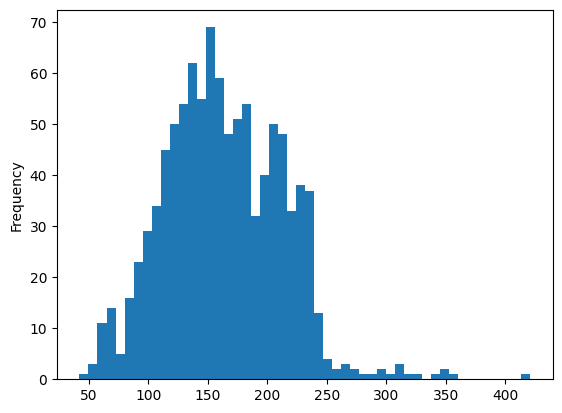

In [5]:
df['Description'].str.len().plot.hist(bins=50)

In [6]:
df['Genre'] = df['Genre'].str.split(',')

genre_counts = [g for gen in df['Genre'] for g in gen]
pd.Series(genre_counts).value_counts()

,count
Drama,513
Action,303
Comedy,279
Adventure,259
Thriller,195
Crime,150
Romance,141
Sci-Fi,120
Horror,119
Mystery,106


## Label Encoder MultiLabel with MultiLabelBinarizer

MultiLabelBinarizer() to encode the label, which is a class in the scikit-learn library for Python. It is used to transform multi-label labels into a binary representation for use in machine learning algorithms. It converts a label array of multiple classes into a binary matrix where each column represents one of the possible classes and each row represents an instance.

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel = MultiLabelBinarizer()
labels = multilabel.fit_transform(df['Genre']).astype('float32')
texts = df['Description'].tolist()

In [8]:
labels.shape

(1000, 20)

In [9]:
labels

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
texts[:5]

['A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.',
 'Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.',
 'Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.',
 "In a city of humanoid animals, a hustling theater impresario's attempt to save his theater with a singing competition becomes grander than he anticipates even as its finalists' find that their lives will never be the same.",
 'A secret government agency recruits some of the most dangerous incarcerated super-villains to form a defensive task force. Their first mission: save the world from the apocalypse.']

## Model Building

### Tokenization for DistilBERT
- Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors.
- Tokenization is the step of breaking down a string into the atomic units used in the model

#### DistilBERT

DistilBERT is a smaller, faster and cheaper version of BERT. It has 40% smaller than BERT and runs 60% faster while preserving over 95% of BERT’s performance.

**Introduction to DistilBERT:** DistilBERT, short for "Distill and BERT," is a compact version of the renowned BERT (Bidirectional Encoder Representations from Transformers) model.

**Model Architecture:** It reduces the number of layers and attention heads, resulting in a smaller and faster model.

**Parameter Reduction:** One of DistilBERT's key features is its parameter reduction strategy, achieved by distillation. This involves training the model on a combination of teacher (BERT) and student (DistilBERT).

**Efficiency and Speed:** By reducing the model's size and complexity, DistilBERT achieves a significant speedup during both training and inference.

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/nlp6.3.jpg" width=1000>

In [11]:
import torch
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset


train_texts, val_texts, train_labels, val_labels = train_test_split(texts,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    )

checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint,
                                                            num_labels=len(labels[0]),
                                                            problem_type="multi_label_classification",
                                                            )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
labels[0]

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0.], dtype=float32)

In [13]:
# Lets build custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

        return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': label
                }

The CustomDataset class is an implementation of a custom dataset for use with PyTorch and Hugging Face Transformers. This type of class is useful when you want to prepare data specifically for a machine learning model. Let's go through its main features:

- Constructor (__init__)
    - texts: A list of texts representing examples in the dataset.
    - labels: A list of labels associated with the texts.
    - tokenizer: A tokenizer, a component of Hugging Face Transformers used to convert input texts into a numerical representation understandable by the model.
    - max_len: The maximum length (in terms of tokens) for the text representation.

- __len__ : returns the length of the dataset, i.e., the total number of examples in the dataset.

- __getitem__:  Takes an index idx as input.
Extracts the text and label corresponding to the index idx.
Tokenizes the text using the specified tokenizer, with options such as truncation and padding to ensure all examples have the same length.
Returns a dictionary containing:
    - 'input_ids': The token IDs of the text, flattened into a vector.
    - 'attention_mask': A binary vector indicating which tokens should be attended to (1 for actual tokens, 0 for padding).
    - 'labels': The label of the example.

In essence, this class helps organize data into a format compatible with PyTorch and suitable for training transformer-based machine learning models, such as those provided by Hugging Face. When you instantiate this class and use a DataLoader in PyTorch, you can easily iterate through the data in batches during the training of the model.

In [14]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [ ]:
# val_dataset[0]

In [15]:
# Multi-Label Classification Evaluation Metrics
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch

def multi_labels_metrics(predictions, labels, threshold=0.3):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs>=threshold)] = 1
    y_true = labels

    f1 = f1_score(y_true, y_pred, average = 'macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    hamming = hamming_loss(y_true, y_pred)

    metrics = {
                "roc_auc": roc_auc,
                "hamming_loss": hamming,
                "f1": f1,
                }
    return metrics

def compute_metrics(p:EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_labels_metrics(predictions=preds,
                                  labels=p.label_ids)
    return result

In [16]:
# Training Arguments
from transformers import TrainingArguments, Trainer

batch_size= 8
output_dir = './results'
num_epochs= 5

args = TrainingArguments(per_device_train_batch_size=batch_size,
                        per_device_eval_batch_size=batch_size,
                        output_dir = output_dir,
                        num_train_epochs=num_epochs,
                        save_steps=1000,
                        save_total_limit=2
                        )

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics,
                  )

In [17]:
trainer.train()

Step,Training Loss
500,0.261100


TrainOutput(global_step=500, training_loss=0.2610784606933594, metrics={'train_runtime': 55.7883, 'train_samples_per_second': 71.7, 'train_steps_per_second': 8.962, 'total_flos': 132509921280000.0, 'train_loss': 0.2610784606933594, 'epoch': 5.0})

In [18]:
trainer.evaluate()

{'eval_loss': 0.237625390291214,
 'eval_roc_auc': 0.6370685765363981,
 'eval_hamming_loss': 0.104,
 'eval_f1': 0.34598400510174676,
 'eval_runtime': 0.9544,
 'eval_samples_per_second': 209.563,
 'eval_steps_per_second': 26.195,
 'epoch': 5.0}

In [19]:
trainer.save_model("distilbert-finetuned-imdb-multi-label")

In [20]:
import joblib

joblib.dump(multilabel, "multi-label-binarizer.pkl")

['multi-label-binarizer.pkl']

In [ ]:
!zip -r distilbert.zip "/content/distilbert-finetuned-imdb-multi-label"

  adding: content/distilbert-finetuned-imdb-multi-label/ (stored 0%)
  adding: content/distilbert-finetuned-imdb-multi-label/training_args.bin (deflated 51%)
  adding: content/distilbert-finetuned-imdb-multi-label/config.json (deflated 62%)
  adding: content/distilbert-finetuned-imdb-multi-label/model.safetensors (deflated 8%)


# Predictions

In [21]:
text = "Carol Danvers gets her powers entangled with those of Kamala Khan and Monica Rambeau, forcing them to work together to save the universe."

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [22]:
multilabel.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'], dtype=object)

In [23]:
threshold = 0.3

sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=threshold)] = 1 # convert class after threshold probab.

In [24]:
preds.reshape(1,-1) ## then convert to classes

array([[1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [25]:
multilabel.inverse_transform(preds.reshape(1,-1))

[('Action', 'Adventure', 'Comedy')]